`Kriging.ipynb`: Perform Kriging over Lake Constance Obersee sediments.

Copyright (C) 2024  Benedict V. A. Mittelbach and Alexander S. Brunmayr

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Kriging of OC deposition patterns in Lake Constance 

Import all necessary packages

In [1]:
import shutil
import pathlib
import gzip

import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from rasterio.enums import Resampling
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
from scipy.optimize import lsq_linear
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
import seaborn as sns
from shapely.geometry import Polygon
from shapely.geometry import MultiLineString
from shapely.ops import polygonize

REPODIR = pathlib.Path('.').resolve() # directory of the repository
INPUTDIR = REPODIR / 'input'
OUTPUTDIR = REPODIR / 'output' / 'kriging'
OUTPUTDIR.mkdir(parents=True, exist_ok=True)

Import all necessary files and setup csv of core data

In [2]:
# Import Bathymetry Raster from Wessels, Martin, et al. "Tiefenschärfe–Hochauflösende Vermessung Bodensee." IGKB Blaue Reihe 61 (2016): 1-110.
bathymetry_raster_file = INPUTDIR / 'bathymetry_reprojected' / 'bathymetry_reprojected.tif'

if not bathymetry_raster_file.exists():
    gzfile = INPUTDIR / 'bathymetry_reprojected' / 'bathymetry_reprojected.tif.gz'
    with gzip.open(gzfile, 'rb') as fin, open(bathymetry_raster_file, 'wb') as fout:
        shutil.copyfileobj(fin, fout)
    assert bathymetry_raster_file.exists()


# Import outline of Obersee
lake = gpd.read_file(INPUTDIR / "OberseeConstance")


calculate_data = True #switch to calculate or not (depending if csv already exists/should be recalculated)
if calculate_data:
    #Define function to solve for OC pool contribution 
    def solve_contributions(F14C_measured, d13C_measured, F14C_values, d13C_values):
        # Define the matrix A based on the known values for F14C and d13C of each source
        A = np.array([
            [F14C_values['Aq'], F14C_values['Soil'], F14C_values['Pet']],
            [d13C_values['Aq'], d13C_values['Soil'], d13C_values['Pet']],
            [1, 1, 1]
        ])
        results = []
        # Solve for each set of measured values
        for F14C, d13C in zip(F14C_measured, d13C_measured):
            b = np.array([F14C, d13C, 1])
            res = lsq_linear(A, b, bounds=(0, 1))
            results.append(res.x)
        
        # Convert results to DataFrame
        df = pd.DataFrame(results, columns=['Aq', 'Soil', 'Pet']) 
        return df
    
    # Known values for F14C and d13C of each source for 2011 as resulting from MCMC model
    F14C_values = {
        'Aq': 0.859,
        'Soil': 1.072,
        'Pet': 0
    }
    d13C_values = {
        'Aq': -32.594,
        'Soil': -27.062,
        'Pet': -22.539  
     }
    
    # Import Blattmanns samples througout the lake
    F14C_measured = [0.696,0.831,0.772,0.786,0.759,0.81,0.8,0.85]
    d13C_measured = [-25.381,-29.611,-29.21,-28.37,-29.37,-30.6,-29.96,-30.98]
    
    # Solve for contributions
    df_results = solve_contributions(F14C_measured, d13C_measured, F14C_values, d13C_values)
    df_results['lon'] = [9.599,9.368,9.453,9.547,9.239,9.199,9.117,9.047]
    df_results['lat'] = [47.555,47.600,47.619,47.586,47.682,47.714,47.766,47.806]
    df_results['TOC'] = [1.007,1.903,1.722,1.43,1.98,2.376,3.03,3.277]
    
    # Coordinates of the Rhine outlet
    rhine_outlet_lon = 9.646
    rhine_outlet_lat = 47.806
    
#Define Function to calculate distance from Rhine outlet for points
    def calculate_distance(lon1, lat1, lon2, lat2):
        """Calculate the Euclidean distance between two points."""
        return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
    
    # Calculate distances for each sample point
    distances = calculate_distance(df_results['lon'].values, df_results['lat'].values, rhine_outlet_lon, rhine_outlet_lat)
    df_results['distance'] = distances
    
    # Extract waterdepth at each sample point
    with rasterio.open(bathymetry_raster_file) as src:
        bathymetry_array = src.read(1)
        # Extract depth values for each sample point
        depths = []
        for lon, lat in zip(df_results['lon'], df_results['lat']):
            row, col = src.index(lon, lat)
            depth = bathymetry_array[row, col]
            depths.append(depth)
    
    df_results['depth'] = depths
    
    # Save all results to a table (CSV file)
    df_results.to_csv(OUTPUTDIR / 'contributions_blattmann_present_day.csv', index=False)
    data = df_results
else:
    #Import Dataframe of Blattmann core data
    data = pd.read_csv(OUTPUTDIR / 'contributions_blattmann_present_day.csv')


## Create Data basis for Kriging

In [3]:
# Extract data from the CSV
lons = data['lon'].values
lats = data['lat'].values
Aq = data['Aq'].values
Soil = data['Soil'].values
Pet = data['Pet'].values
TOC = data['TOC'].values
distances = data['distance'].values
depths = data['depth'].values

# Calculate the bounding box of the lake
bounds = lake.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds

# Define a grid of latitude/longitude values based on the bounding box of the lake
grid_lon = np.linspace(min_lon, max_lon, 100)
grid_lat = np.linspace(max_lat, min_lat, 100)  
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Define the Rhine outlet point
rhine_outlet = Point(9.646, 47.523)

# Filter the grid points to only include those within the lake boundary
lake_boundary = lake.geometry.iloc[0]
inside_lake = np.array([[Point(x, y).within(lake_boundary) for x, y in zip(lon_row, lat_row)] for lon_row, lat_row in zip(grid_lon, grid_lat)])
filtered_lon = grid_lon[inside_lake]
filtered_lat = grid_lat[inside_lake]

# Extract bathymetry values for the grid points and calculate distances from Rhine outlet
with rasterio.open(bathymetry_raster_file) as src:
    transform = src.transform
    new_transform = rasterio.transform.from_bounds(min_lon, min_lat, max_lon, max_lat, grid_lon.shape[1], grid_lat.shape[0])
    grid_depths = np.empty((grid_lat.shape[0], grid_lon.shape[1]), dtype=src.dtypes[0])
    reproject(
        source=rasterio.band(src, 1),
        destination=grid_depths,
        src_transform=transform,
        src_crs=src.crs,
        dst_transform=new_transform,
        dst_crs=src.crs,
        resampling=Resampling.bilinear
    )

grid_depths[grid_depths == -9999] = 0 

# Calculate distance from Rhine outlet and river plume for the grid points
grid_distances = np.array([[Point(x, y).distance(rhine_outlet) for x, y in zip(lon_row, lat_row)] for lon_row, lat_row in zip(grid_lon, grid_lat)])
# Filter the grid depths, distances, and river plume distances to only include those within the lake boundary
filtered_depths = grid_depths[inside_lake]
filtered_distances = grid_distances[inside_lake]


Calculate Area of grid cells

In [4]:
# Determine the dimensions for the grid based on 'inside_lake'
num_rows, num_cols = inside_lake.shape

# Get polygons from a grid of lat/lon endpoints
# Solution from https://stackoverflow.com/a/37055245
x = np.linspace(min_lon, max_lon, num=num_cols)
y = np.linspace(max_lat, min_lat, num=num_rows)
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(x[:-1], x[1:]) for yi in y]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(y[:-1], y[1:]) for xi in x]
polygons = list(polygonize(MultiLineString(hlines + vlines)))
gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:4326')
gdf_polygons = gdf_polygons.to_crs(gdf_polygons.estimate_utm_crs())
areas = gdf_polygons['geometry'].area.values

lake_geom = lake.to_crs(gdf_polygons.crs).geometry.item()

grid_cell_areas = gdf_polygons['geometry'].area.values
grid_cell_areas_inside_lake = gdf_polygons.intersection(lake_geom).area.values
grid_cell_area = max(grid_cell_areas_inside_lake)
surface_area_lake = np.nansum(grid_cell_areas_inside_lake)

## Define Kriging Routine and Plotting function 

In [5]:
def perform_kriging(lons, lats, values, depths, distances, title, lake):
    # Kriging Interpolation with drift terms
    UK = UniversalKriging(
        lons, lats, values, variogram_model='exponential',
        drift_terms=['specified'], specified_drift=[depths, distances],
        verbose=True, enable_plotting=False
    )
    z, ss = UK.execute('points', filtered_lon, filtered_lat, specified_drift_arrays=[filtered_depths, filtered_distances])
    
    # Ensure non-negative values
    z[z < 0] = 0
    # Create an empty grid filled with NaN
    z_reshaped = np.full(grid_lon.shape, np.nan) 
    # Assign kriged values only to positions inside the lake boundary, outside stays nan
    z_reshaped[inside_lake] = z 
    SS = np.sqrt(ss)
    SS_reshaped = np.full(grid_lon.shape, np.nan)
    SS_reshaped[inside_lake] = SS
    return z_reshaped,SS_reshaped

def plot_kriged_values(axs, grid_lon, grid_lat, kriged_values, uncertainties, lons, lats, title, lake, vmin=None, vmax=None):
    # Increase font sizes for the plots
    font_size = 18
    scatter_size = 50
    lines = 2

    # Plot the kriged values with lake boundary and data points
    contour_values = axs[0].contourf(grid_lon, grid_lat, kriged_values, 50, cmap="coolwarm", vmin=vmin, vmax=vmax)
    lake.boundary.plot(ax=axs[0], color='k', linewidth=lines)
    axs[0].scatter(lons, lats, color='black', edgecolor='white', linewidth=1, s=scatter_size, label='Data Points')
    axs[0].set_title(title + ' (Kriged Values)', fontsize=font_size)
    cax_values = axs[0].inset_axes([1.05, 0, 0.05, 1], transform=axs[0].transAxes)
    cbar_values = plt.colorbar(contour_values, cax=cax_values, label='Value')
    cbar_values.ax.tick_params(labelsize=font_size)

    # Plot the uncertainties with lake boundary and data points
    contour_uncertainty = axs[1].contourf(grid_lon, grid_lat, uncertainties, 50, cmap="OrRd")
    lake.boundary.plot(ax=axs[1], color='k', linewidth=lines)
    axs[1].scatter(lons, lats, color='black', edgecolor='white', linewidth=1, s=scatter_size, label='Data Points')
    axs[1].set_title(title + ' (Uncertainty)', fontsize=font_size)
    cax_uncertainty = axs[1].inset_axes([1.05, 0, 0.05, 1], transform=axs[1].transAxes)
    cbar_uncertainty = plt.colorbar(contour_uncertainty, cax=cax_uncertainty, label='Uncertainty')
    cbar_uncertainty.ax.tick_params(labelsize=font_size)

    # Increase font size for the axis labels and ticks
    for ax in axs:
        ax.set_xlabel('Longitude', fontsize=font_size)
        ax.set_ylabel('Latitude', fontsize=font_size)
        ax.tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()



Perform Kriging of Aquatic, Soil and Pet contribution as well as TOC content and plot 

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.09906251922922135
Full Sill: 0.0990625192292438
Range: 0.5596024911455688
Nugget: 2.2452693367615073e-14 

Calculating statistics on variogram model fit...
Q1 = 0.8965086971838514
Q2 = 0.8802917383601035
cR = 0.0587652363718405 

Initializing drift terms...
Executing Universal Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.04183826594287772
Full Sill: 0.04183826594287802
Range: 0.55960249114643
Nugget: 2.998651874401684e-16 

Calculating statistics on variogram model fit...
Q1 = 0.8633056045445945
Q2 = 0.7783457442802693
cR = 0.021944754392220624 

Initializing drift terms...
Executing Universal Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.01261125294769631
Full Sill: 0.01261125294769631
Range: 0.55960249114

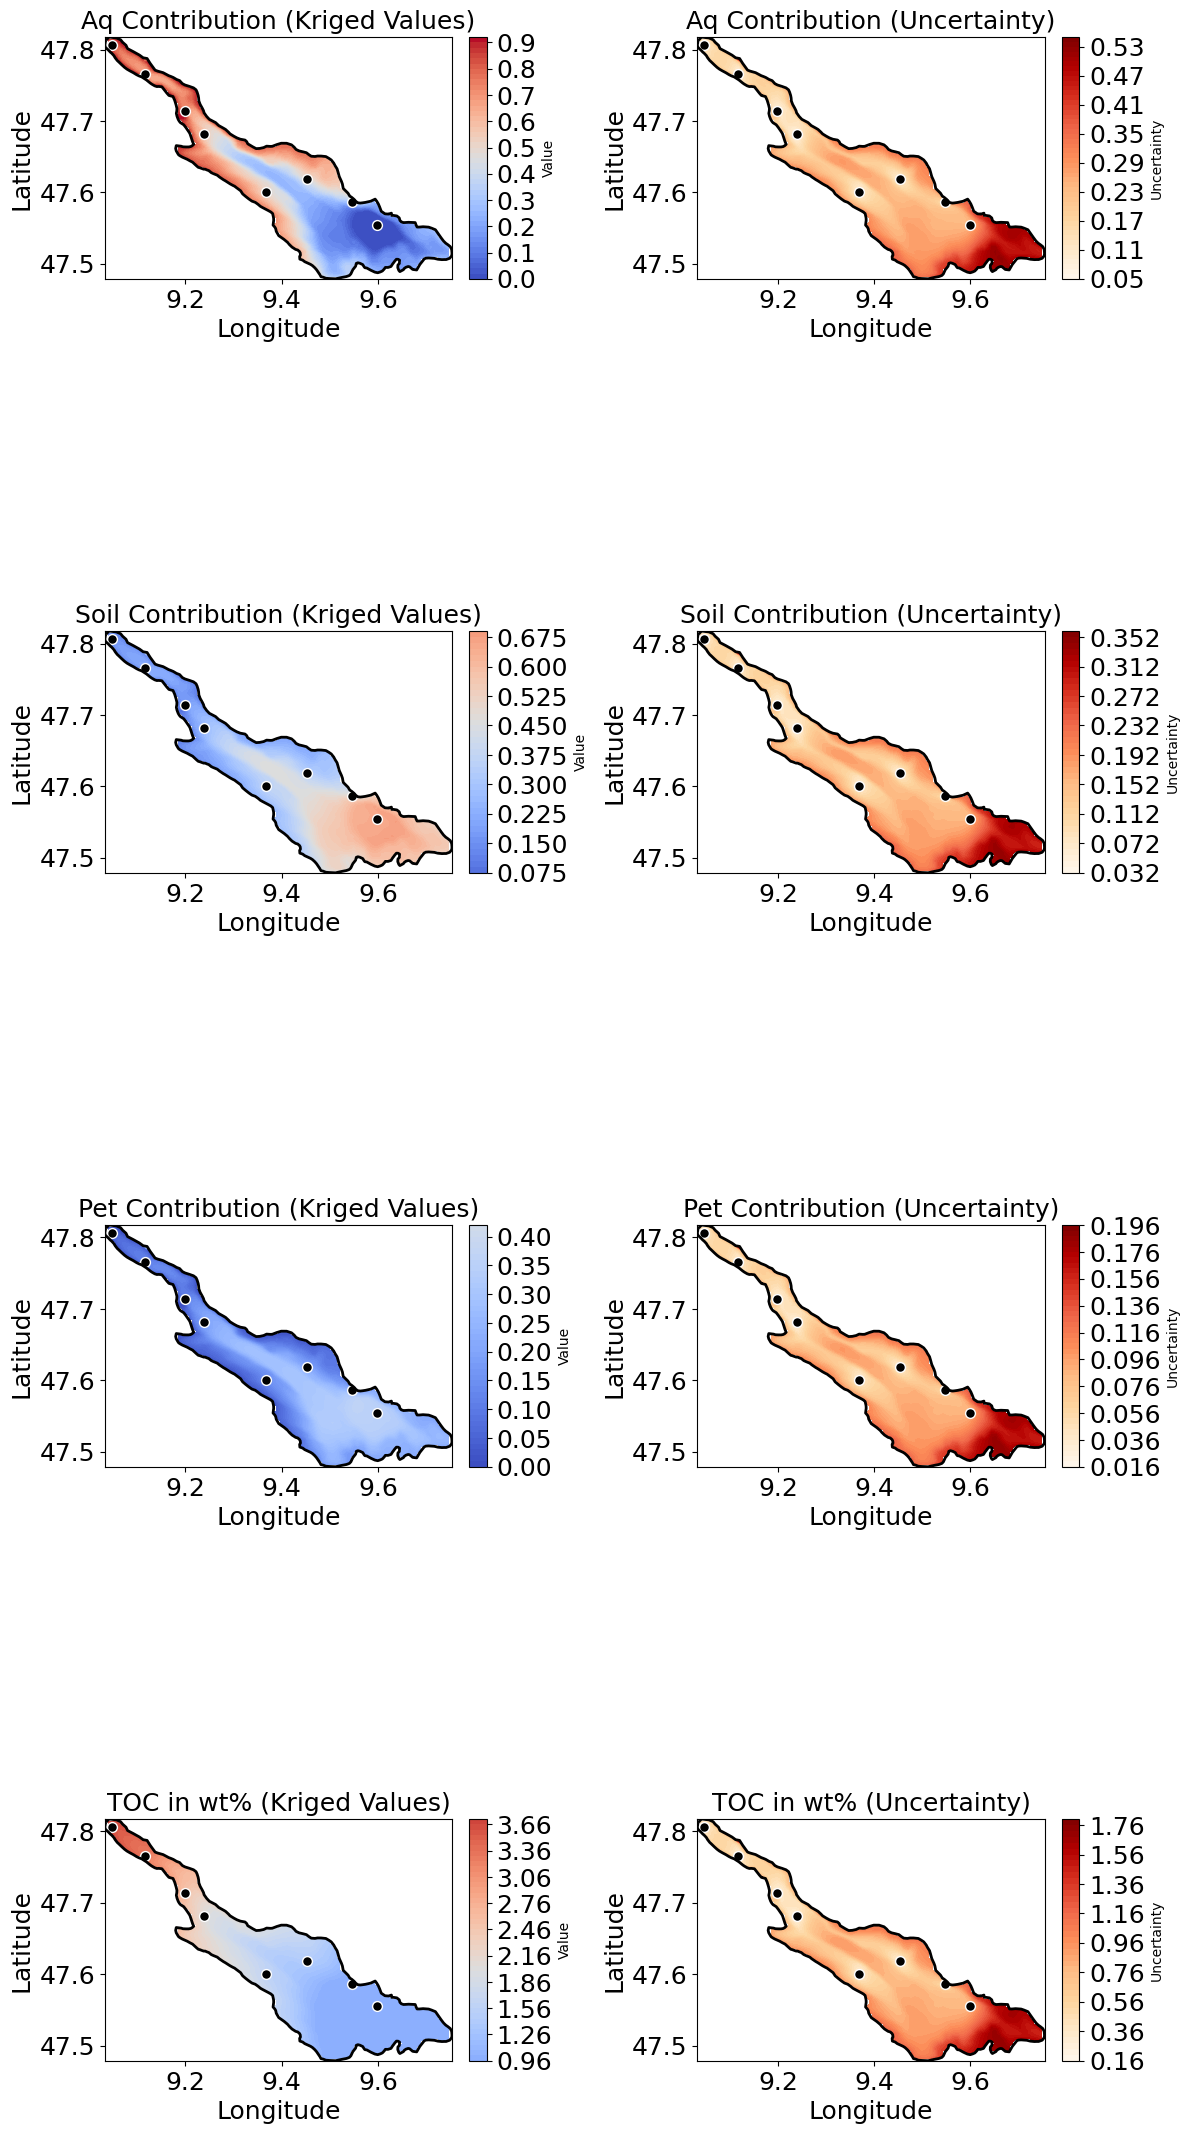

In [6]:
# Kriging for Aq, Soil, and Pet
Aq_kriged, Aq_uncertainty = perform_kriging(lons, lats, Aq, data['depth'], data['distance'], 'Kriging Interpolation of Aq Contribution', lake)
Soil_kriged, Soil_uncertainty = perform_kriging(lons, lats, Soil, data['depth'], data['distance'], 'Kriging Interpolation of Soil Contribution', lake)
Pet_kriged,Pet_uncertainty = perform_kriging(lons, lats, Pet, data['depth'], data['distance'], 'Kriging Interpolation of Pet Contribution', lake)
TOC_kriged, TOC_uncertainty = perform_kriging(lons, lats, TOC, data['depth'], data['distance'], 'Kriging Interpolation of TOC in wt%', lake)

#Adjustlowest TOC sample to lowest observed to prevent toc trending to 0 
min_TOC_value = np.min(TOC)
TOC_kriged[TOC_kriged < min_TOC_value] = min_TOC_value
# Normalize the kriged values so they sum to 1
total = Aq_kriged + Soil_kriged + Pet_kriged
Aq_kriged /= total
Soil_kriged /= total
Pet_kriged /= total


# Determine the global color scale limits
global_vmin = min(np.nanmin(Aq_kriged), np.nanmin(Soil_kriged), np.nanmin(Pet_kriged))
global_vmax = max(np.nanmax(Aq_kriged), np.nanmax(Soil_kriged), np.nanmax(Pet_kriged))

# The figure will have two columns: one for kriged values and one for uncertainties
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 24)) 

# Plot each variable with its uncertainty next to it
plot_kriged_values([axes[0, 0], axes[0, 1]], grid_lon, grid_lat, Aq_kriged, Aq_uncertainty, lons, lats, 'Aq Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[1, 0], axes[1, 1]], grid_lon, grid_lat, Soil_kriged, Soil_uncertainty, lons, lats, 'Soil Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[2, 0], axes[2, 1]], grid_lon, grid_lat, Pet_kriged, Pet_uncertainty, lons, lats, 'Pet Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[3, 0], axes[3, 1]], grid_lon, grid_lat, TOC_kriged, TOC_uncertainty, lons, lats, 'TOC in wt%', lake, 0, 4) 

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

fig.savefig(OUTPUTDIR / "KrigingMapsRaw_NEW.svg", format="svg", dpi=600)

plt.show()

Get Map of mass accumulation rate

In [7]:
calculate_acc = True  #true to extract values from shapefile 
if calculate_acc:
    # Load the ACCrateShape shapefile
    ACCrateShape = gpd.read_file(INPUTDIR / "DominikAccRate")

    # Extract coordinates and rate values
    ACCrateShape_lons = ACCrateShape.geometry.x.values
    ACCrateShape_lats = ACCrateShape.geometry.y.values
    rate_values = ACCrateShape["Rate"].values
    
    # Extract bathymetry values for the points
    with rasterio.open(bathymetry_raster_file) as src:
        ACCrateShape_depths = [src.read(1)[src.index(lon, lat)] for lon, lat in zip(ACCrateShape_lons, ACCrateShape_lats)]
    
    # Coordinates of the Rhine outlet
    rhine_outlet_lon = 9.646
    rhine_outlet_lat = 47.806
    
    # Calculate distance from Rhine outlet for each point
    def calculate_distance(lon1, lat1, lon2, lat2):
        return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
    
    ACCrateShape_distances = [calculate_distance(lon, lat, rhine_outlet_lon, rhine_outlet_lat) for lon, lat in zip(ACCrateShape_lons, ACCrateShape_lats)]
    
    # Create a DataFrame
    data2 = pd.DataFrame({
        'Longitude': ACCrateShape_lons,
        'Latitude': ACCrateShape_lats,
        'Mass_Accumulation_Rate': rate_values,
        'Depth': ACCrateShape_depths,
        'Distance_from_Rhine': ACCrateShape_distances
    })
    
    # Export to CSV
    data2.to_csv(OUTPUTDIR / 'ACCrateShape_data.csv', index=False)
else: 
    data2 = pd.read_csv(OUTPUTDIR / "ACCrateShape_data.csv")
    

In [8]:
# Extract data
lons = data2['Longitude'].values
lats = data2['Latitude'].values
MAR = data2['Mass_Accumulation_Rate'].values
depths = data2['Depth'].values
distances = data2['Distance_from_Rhine'].values

# Calculate the bounding box of the lake
bounds = lake.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds

# Define a grid of latitude/longitude values
grid_lon = np.linspace(min_lon, max_lon, 100)
grid_lat = np.linspace(max_lat, min_lat, 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Filter the grid points within the lake boundary
lake_boundary = lake.geometry.iloc[0]
inside_lake = np.array([[Point(x, y).within(lake_boundary) for x, y in zip(lon_row, lat_row)] for lon_row, lat_row in zip(grid_lon, grid_lat)])
filtered_lon = grid_lon[inside_lake]
filtered_lat = grid_lat[inside_lake]

# Extract bathymetry values for the filtered grid points
with rasterio.open(bathymetry_raster_file) as src:
    transform = src.transform
    new_transform = rasterio.transform.from_bounds(min_lon, min_lat, max_lon, max_lat, grid_lon.shape[1], grid_lat.shape[0])
    grid_depths = np.empty((grid_lat.shape[0], grid_lon.shape[1]), dtype=src.dtypes[0])
    reproject(
        source=rasterio.band(src, 1),
        destination=grid_depths,
        src_transform=transform,
        src_crs=src.crs,
        dst_transform=new_transform,
        dst_crs=src.crs,
        resampling=Resampling.bilinear
    )
grid_depths[grid_depths == -9999] = 0



## Perform Kriging of Accumulation Rate

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.40074574690774406
Full Sill: 0.4007457469077463
Range: 0.4780714018490023
Nugget: 2.2190169831761426e-15 

Calculating statistics on variogram model fit...
Q1 = 0.16710718105726555
Q2 = 0.28332371812166024
cR = 0.0327226304618498 

Initializing drift terms...
Executing Universal Kriging...



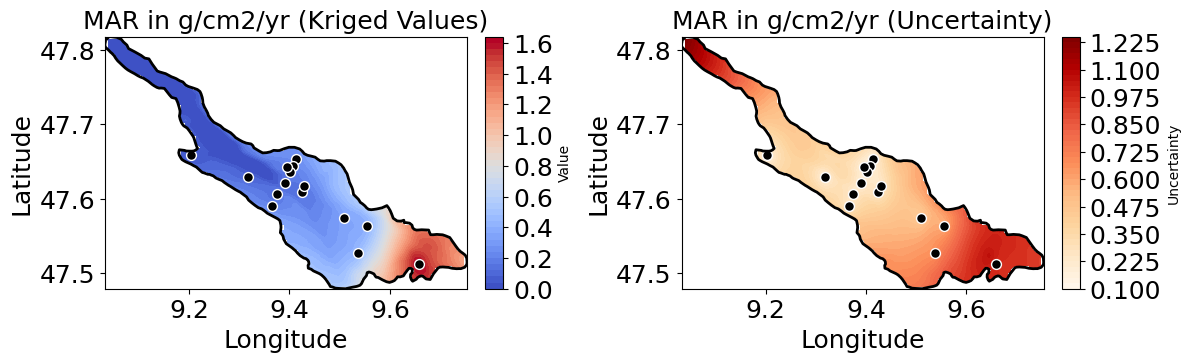

In [9]:
Acc_kriged, Acc_uncertainty = perform_kriging(lons, lats, MAR, depths, distances, 'Kriging Interpolation of Acc', lake)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 

# Plot each variable with its uncertainty next to it
plot_kriged_values([axes[0], axes[1]], grid_lon, grid_lat, Acc_kriged, Acc_uncertainty, lons, lats, 'MAR in g/cm2/yr', lake, 0, 1.6)

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

fig.savefig(OUTPUTDIR / "KrigingMapsRaw_MAR_NEW.svg", format="svg", dpi=600)


plt.show()

Quantify the total Mass Accumulation and total pool weighted TOC accumulation 

In [10]:
# needed to nicely format data
def scientific_format(num):    
    exponent = int(np.floor(np.log10(abs(num))))
    base = num / (10**exponent)
    return "{:.2f} x 10^{}".format(base, exponent)


In [11]:
#Surface area in m2
surface_area_lake = np.nansum(grid_cell_areas_inside_lake)

#as rate is in g/cm2
grid_cell_area_cm2 = grid_cell_area * 10000  # 1 m2 = 10,000 cm2

# Calculate the total mass accumulation in grams for the entire region
Acc_total = Acc_kriged * grid_cell_area_cm2  # Now in correct units (g/yr)
total_Acc = np.nansum(Acc_total)  # Total accumulation in grams per year
# Convert the total accumulation to a scientific format for display
total_Acc_formatted = scientific_format(total_Acc)

#upper estimate
Acc_total_upper = (Acc_kriged + Acc_uncertainty) * grid_cell_area_cm2
total_Acc_upper = np.nansum(Acc_total_upper) 
total_Acc_form_upper = scientific_format(total_Acc_upper)

print(f"Total Mass Accumulation: {total_Acc_formatted} g/yr using cm2")
print(f"Total Mass Accumulation upper estimate: {total_Acc_form_upper} g/yr using cm2")
# A total of 3.7 * 10^12 is expected annually, so it agrees within error.

Total Mass Accumulation: 2.00 x 10^12 g/yr using cm2
Total Mass Accumulation upper estimate: 4.81 x 10^12 g/yr using cm2


In [12]:
# 1. Calculate the Accumulation Rates for Each Carbon Pool
Acc_Aq = TOC_kriged/100 * Acc_total * Aq_kriged
Acc_Soil = TOC_kriged/100 * Acc_total * Soil_kriged
Acc_Pet = TOC_kriged/100 * Acc_total * Pet_kriged

# compute the total accumulation, in grams total_Aq = np.nansum(Acc_Aq)
total_Aq = np.nansum(Acc_Aq)
total_Soil = np.nansum(Acc_Soil)
total_Pet = np.nansum(Acc_Pet)
total_OC = total_Aq + total_Soil + total_Pet

total_Aq_formatted = scientific_format(total_Aq)
total_Soil_formatted = scientific_format(total_Soil)
total_Pet_formatted = scientific_format(total_Pet)
total_OC_formatted = scientific_format(total_OC)

# get TOC MAR
OC_MAR = total_OC /surface_area_lake


print(f'Accumulation Rate of Aquatic OC per year\nTotal Accumulation: {total_Aq_formatted} g/yr\n')
print(f'Accumulation Rate of Soil OC per year\nTotal Accumulation: {total_Soil_formatted} g/yr\n')
print(f'Accumulation Rate of Pet OC per year\nTotal Accumulation: {total_Pet_formatted} g/yr\n')
print(f'Accumulation Rate of TOC per year\nTotal Accumulation: {total_OC_formatted} g/yr\n')
print(f'Accumulation Rate of TOC per year\n in g/m2/yr: {OC_MAR} g/m2/yr\n')


Accumulation Rate of Aquatic OC per year
Total Accumulation: 6.15 x 10^9 g/yr

Accumulation Rate of Soil OC per year
Total Accumulation: 1.12 x 10^10 g/yr

Accumulation Rate of Pet OC per year
Total Accumulation: 5.07 x 10^9 g/yr

Accumulation Rate of TOC per year
Total Accumulation: 2.25 x 10^10 g/yr

Accumulation Rate of TOC per year
 in g/m2/yr: 47.3107577527379 g/m2/yr



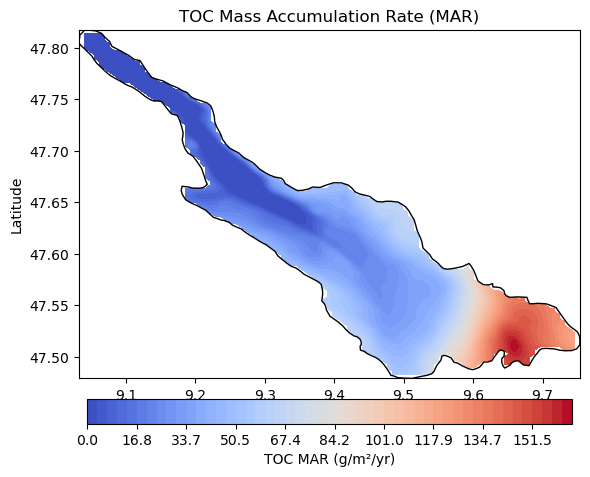

In [13]:
# Calculate TOC MAR for each grid cell
TOC_MAR_map = (Acc_Aq + Acc_Soil + Acc_Pet) / (grid_cell_area_cm2/10000)

# Flatten the arrays and remove NaN values
flat_TOC_MAR = TOC_MAR_map.flatten()
flat_TOC_MAR = flat_TOC_MAR[~np.isnan(flat_TOC_MAR)]

# Find min and max values that are not NaN
vmin = np.min(flat_TOC_MAR)
vmax = np.max(flat_TOC_MAR)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# Create the contour plot with automatic color scaling
contour = ax.contourf(grid_lon, grid_lat, TOC_MAR_map, levels=np.linspace(vmin, vmax, 50), cmap="coolwarm")
plt.colorbar(contour, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, label="TOC MAR (g/m²/yr)")

# Draw the lake boundary
lake.boundary.plot(ax=ax, color='k', linewidth=1)

# Set title and axes labels
ax.set_title("TOC Mass Accumulation Rate (MAR)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR / "KrigingMapsRaw_TOCMAR_NEW.svg", format="svg", dpi=600)


Get Uncertainty of Burial Fluxes with MC simulations

In [14]:
import numpy as np

# Number of simulations
N = 10000

# Arrays to store results
burial_flux_Aq_simulations = np.zeros(N)
burial_flux_Soil_simulations = np.zeros(N)
burial_flux_Pet_simulations = np.zeros(N)
TOC_flux_simulations = np.zeros(N)

OC_MAR_simulations = np.zeros(N)
OC_AqMAR_simulations = np.zeros(N)
OC_SoilMAR_simulations = np.zeros(N)
OC_PetMAR_simulations = np.zeros(N)


# Using kriged maps and uncertainties from your existing code
kriged_maps = [Aq_kriged, Soil_kriged, Pet_kriged]
uncertainty_maps = [Aq_uncertainty, Soil_uncertainty, Pet_uncertainty]


for i in range(N):
    # Randomly sample values based on uncertainties
    sampled_maps = [kriged + np.random.uniform(-3, 3, size=kriged.shape) * uncertainty for kriged, uncertainty in zip(kriged_maps, uncertainty_maps)] 
    # Calculate burial flux for each carbon pool using sampled values and multiply by grid cell area
    burial_flux_Aq_simulations[i] = np.nansum(sampled_maps[0] * (TOC_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    burial_flux_Soil_simulations[i] = np.nansum(sampled_maps[1] * (TOC_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    burial_flux_Pet_simulations[i] = np.nansum(sampled_maps[2] * (TOC_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    TOC_flux_simulations[i] = burial_flux_Aq_simulations[i] + burial_flux_Soil_simulations[i] + burial_flux_Pet_simulations[i]
    
    OC_MAR_simulations[i] = np.nansum((burial_flux_Aq_simulations[i] + burial_flux_Soil_simulations[i] + burial_flux_Pet_simulations[i]) / surface_area_lake)
    OC_AqMAR_simulations[i] = burial_flux_Aq_simulations[i] / surface_area_lake
    OC_SoilMAR_simulations[i] = burial_flux_Soil_simulations[i] / surface_area_lake
    OC_PetMAR_simulations[i] = burial_flux_Pet_simulations[i] / surface_area_lake
        
# Calculate mean and standard deviation of everything
mean_Aq = np.mean(burial_flux_Aq_simulations)
std_Aq = np.std(burial_flux_Aq_simulations)
mean_Soil = np.mean(burial_flux_Soil_simulations)
std_Soil = np.std(burial_flux_Soil_simulations)
mean_Pet = np.mean(burial_flux_Pet_simulations)
std_Pet = np.std(burial_flux_Pet_simulations)
mean_TOC = np.mean(TOC_flux_simulations)
std_TOC = np.std(TOC_flux_simulations)


mean_OC_MAR = np.mean(OC_MAR_simulations)
std_OC_MAR = np.std(OC_MAR_simulations)
mean_AqOC_MAR = np.mean(OC_AqMAR_simulations)
std_AqOC_MAR = np.std(OC_AqMAR_simulations)
mean_SoilOC_MAR = np.mean(OC_SoilMAR_simulations)
std_SoilOC_MAR = np.std(OC_SoilMAR_simulations)
mean_PetOC_MAR = np.mean(OC_PetMAR_simulations)
std_PetOC_MAR = np.std(OC_PetMAR_simulations)


print(f"Aq: {mean_Aq:.2e} ± {std_Aq:.2e}")
print(f"Soil: {mean_Soil:.2e} ± {std_Soil:.2e}")
print(f"Pet: {mean_Pet:.2e} ± {std_Pet:.2e}")
print(f"TOC: {mean_TOC:.2e} ± {std_TOC:.2e}")

print(f"OC MAR: {mean_OC_MAR:.2e} ± {std_OC_MAR:.2e} g/m²/yr")
print(f"OCAq MAR: {mean_AqOC_MAR:.2e} ± {std_AqOC_MAR:.2e} g/m²/yr")
print(f"OCSoil MAR: {mean_SoilOC_MAR:.2e} ± {std_SoilOC_MAR:.2e} g/m²/yr")
print(f"OCPet MAR: {mean_PetOC_MAR:.2e} ± {std_PetOC_MAR:.2e} g/m²/yr")

Aq: 6.15e+09 ± 4.45e+08
Soil: 1.12e+10 ± 2.96e+08
Pet: 5.07e+09 ± 1.61e+08
TOC: 2.25e+10 ± 5.65e+08
OC MAR: 4.73e+01 ± 1.19e+00 g/m²/yr
OCAq MAR: 1.30e+01 ± 9.38e-01 g/m²/yr
OCSoil MAR: 2.37e+01 ± 6.24e-01 g/m²/yr
OCPet MAR: 1.07e+01 ± 3.39e-01 g/m²/yr


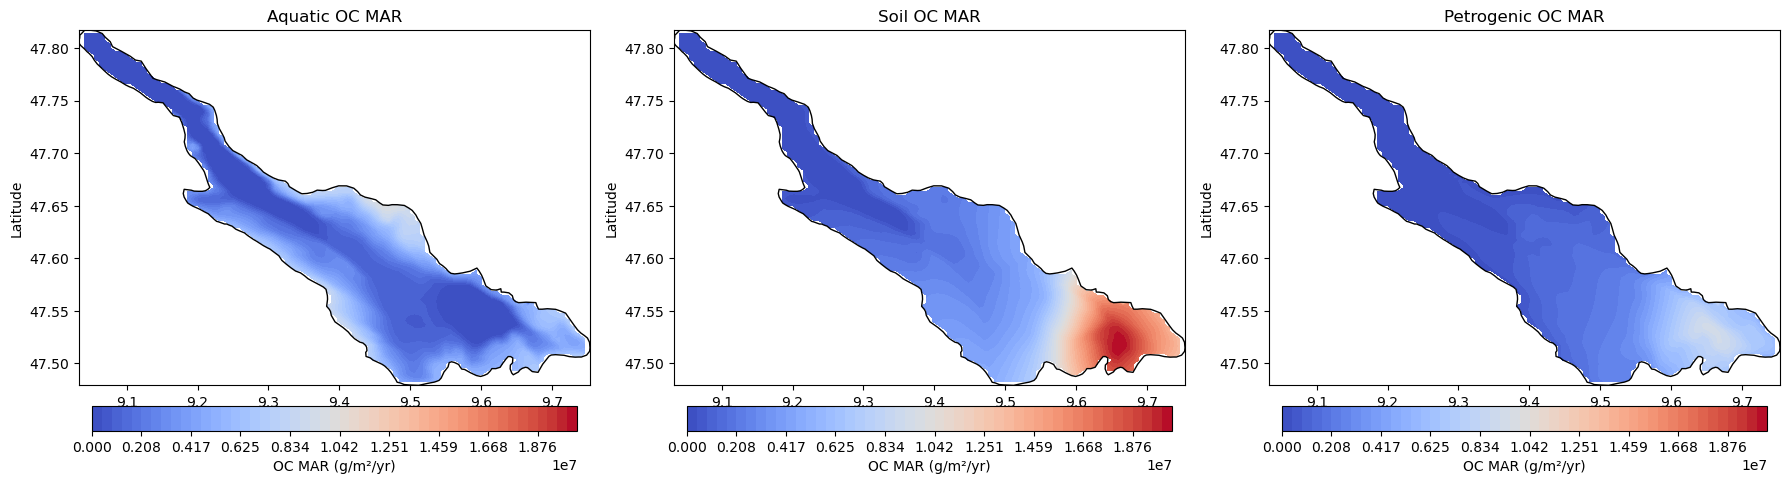

In [15]:
# Calculate global color scale limits
all_data = np.concatenate([Acc_Aq.flatten(), Acc_Soil.flatten(), Acc_Pet.flatten()])
all_data = all_data[~np.isnan(all_data)]  # Remove NaN values
global_vmin = np.min(all_data)
global_vmax = np.max(all_data)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define a common contour plot function
def plot_mar(ax, data, title, cmap):
    contour = ax.contourf(grid_lon, grid_lat, data, levels=np.linspace(global_vmin, global_vmax, 50), cmap=cmap)
    plt.colorbar(contour, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, label="OC MAR (g/m²/yr)")
    lake.boundary.plot(ax=ax, color='k', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Plot each OC MAR type
plot_mar(axs[0], Acc_Aq, "Aquatic OC MAR", "coolwarm")
plot_mar(axs[1], Acc_Soil, "Soil OC MAR", "coolwarm")
plot_mar(axs[2], Acc_Pet, "Petrogenic OC MAR", "coolwarm")

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR / "OC_MAR_Comparison.svg", format="svg", dpi=600)


# Kriging for long term storage/ pre-bomb 


In [16]:
#Known values for F14C and d13C of each source for pre bomb state
calculate_pre = True

if calculate_pre: 
    F14C_values = {
        'Aq': 0.795, #in 1910
        'Soil': 0.986, #in 1910
        'Pet': 0
    }
    d13C_values = {
        'Aq': -32.554,
        'Soil': -27.167,
        'Pet': -22.546
    }
    # Blattmann data
    F14C_measured_raw = np.array([0.524, 0.495, 0.579, 0.756, 0.7265,0.7610])
    
    # Calculate for radicarbon decay
    years_measured = np.array([1207, 1734, 1705, 1630, 1782,1919])
    year_of_measurement = np.array([2013,2013,2013,2013,2013,2021])
    # Decay constant for radiocarbon
    decay_constant = 1.21e-4
    # Calculate the time elapsed since the sample was deposited (in years)
    time_elapsed = year_of_measurement - years_measured
    # Calculate the fraction of radiocarbon at the time of deposition (F0) for each sample
    F14C_measured = F14C_measured_raw * np.exp(decay_constant * time_elapsed)
    d13C_measured = [-25.6,-25.239,-26.10235,-26.938,-26.833,-27.91]
    TOC_measured = [0.844,0.6983,0.845607,1.248,1.35,1.04]
    
    # Solve for contributions
    df_results = solve_contributions(F14C_measured, d13C_measured, F14C_values, d13C_values)
    df_results['lon'] = [9.368,9.453,9.239,9.117,9.047,9.547]
    df_results['lat'] = [47.600,47.619,47.682,47.766,47.806,47.586]
    df_results['TOC'] = TOC_measured
    
    # Calculate distances for each sample point
    distances = calculate_distance(df_results['lon'].values, df_results['lat'].values, rhine_outlet_lon, rhine_outlet_lat)
    df_results['distance'] = distances
    
    # Load the .asc bathymetry file
    with rasterio.open(bathymetry_raster_file) as src:
        bathymetry_array = src.read(1)
    
        # Extract depth values for each sample point
        depths = []
        for lon, lat in zip(df_results['lon'], df_results['lat']):
            row, col = src.index(lon, lat)
            depth = bathymetry_array[row, col]
            depths.append(depth)
    
    df_results['depth'] = depths
    # Save results to a table (CSV file)
    df_results.to_csv(OUTPUTDIR / 'contributions_blattmann_prebomb.csv', index=False)
    data = df_results
else: 
    data = pd.read_csv(OUTPUTDIR / 'contributions_blattmann_prebomb.csv')

In [17]:
 # Extract data from the CSV
lons = data['lon'].values
lats = data['lat'].values
Aq = data['Aq'].values
Soil = data['Soil'].values
Pet = data['Pet'].values
TOC = data['TOC'].values
distances = data['distance'].values
depths = data['depth'].values

Aq_pre_kriged, Aq_pre_uncertainty = perform_kriging(lons, lats, Aq, data['depth'], data['distance'], 'Kriging Interpolation of pre bomb Aq Contribution', lake)
Soil_pre_kriged, Soil_pre_uncertainty = perform_kriging(lons, lats, Soil, data['depth'], data['distance'], 'Kriging Interpolation of pre bomb Soil Contribution', lake)
Pet_pre_kriged,Pet_pre_uncertainty = perform_kriging(lons, lats, Pet, data['depth'], data['distance'], 'Kriging Interpolation of pre bomb Pet Contribution', lake)
TOC_pre_kriged, TOC_pre_uncertainty = perform_kriging(lons, lats, TOC, data['depth'], data['distance'], 'Kriging Interpolation of pre bomb TOC in wt%', lake)

#Adjustlowest TOC sample to lowest observed to prevent toc trending to 0 
min_TOC_pre_value = np.min(TOC)
TOC_pre_kriged[TOC_pre_kriged < min_TOC_pre_value] = min_TOC_pre_value

max_TOC_pre_value = np.max(TOC)
TOC_pre_kriged[TOC_pre_kriged > max_TOC_pre_value] = max_TOC_pre_value

# Normalize the kriged values so they sum to 1
total = Aq_pre_kriged + Soil_pre_kriged + Pet_pre_kriged
Aq_pre_kriged /= total
Soil_pre_kriged /= total
Pet_pre_kriged /= total

# Determine the global color scale limits
global_vmin = min(np.nanmin(Aq_pre_kriged), np.nanmin(Soil_pre_kriged), np.nanmin(Pet_pre_kriged))
global_vmax = max(np.nanmax(Aq_pre_kriged), np.nanmax(Soil_pre_kriged), np.nanmax(Pet_pre_kriged))

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.005990486092276172
Full Sill: 0.008465257584405238
Range: 0.546260011325839
Nugget: 0.002474771492129066 

Calculating statistics on variogram model fit...
Q1 = 0.8664804886946064
Q2 = 1.5262871349633556
cR = 0.013520803179415666 

Initializing drift terms...
Executing Universal Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.01117472023362006
Full Sill: 0.011174720233689385
Range: 0.45892777908964066
Nugget: 6.9323988153668e-14 

Calculating statistics on variogram model fit...
Q1 = 0.3696960686077164
Q2 = 0.9855003494305473
cR = 0.010103754368046901 

Initializing drift terms...
Executing Universal Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.01710810468594475
Full Sill: 0.0171081047131276
Range: 0.17442112

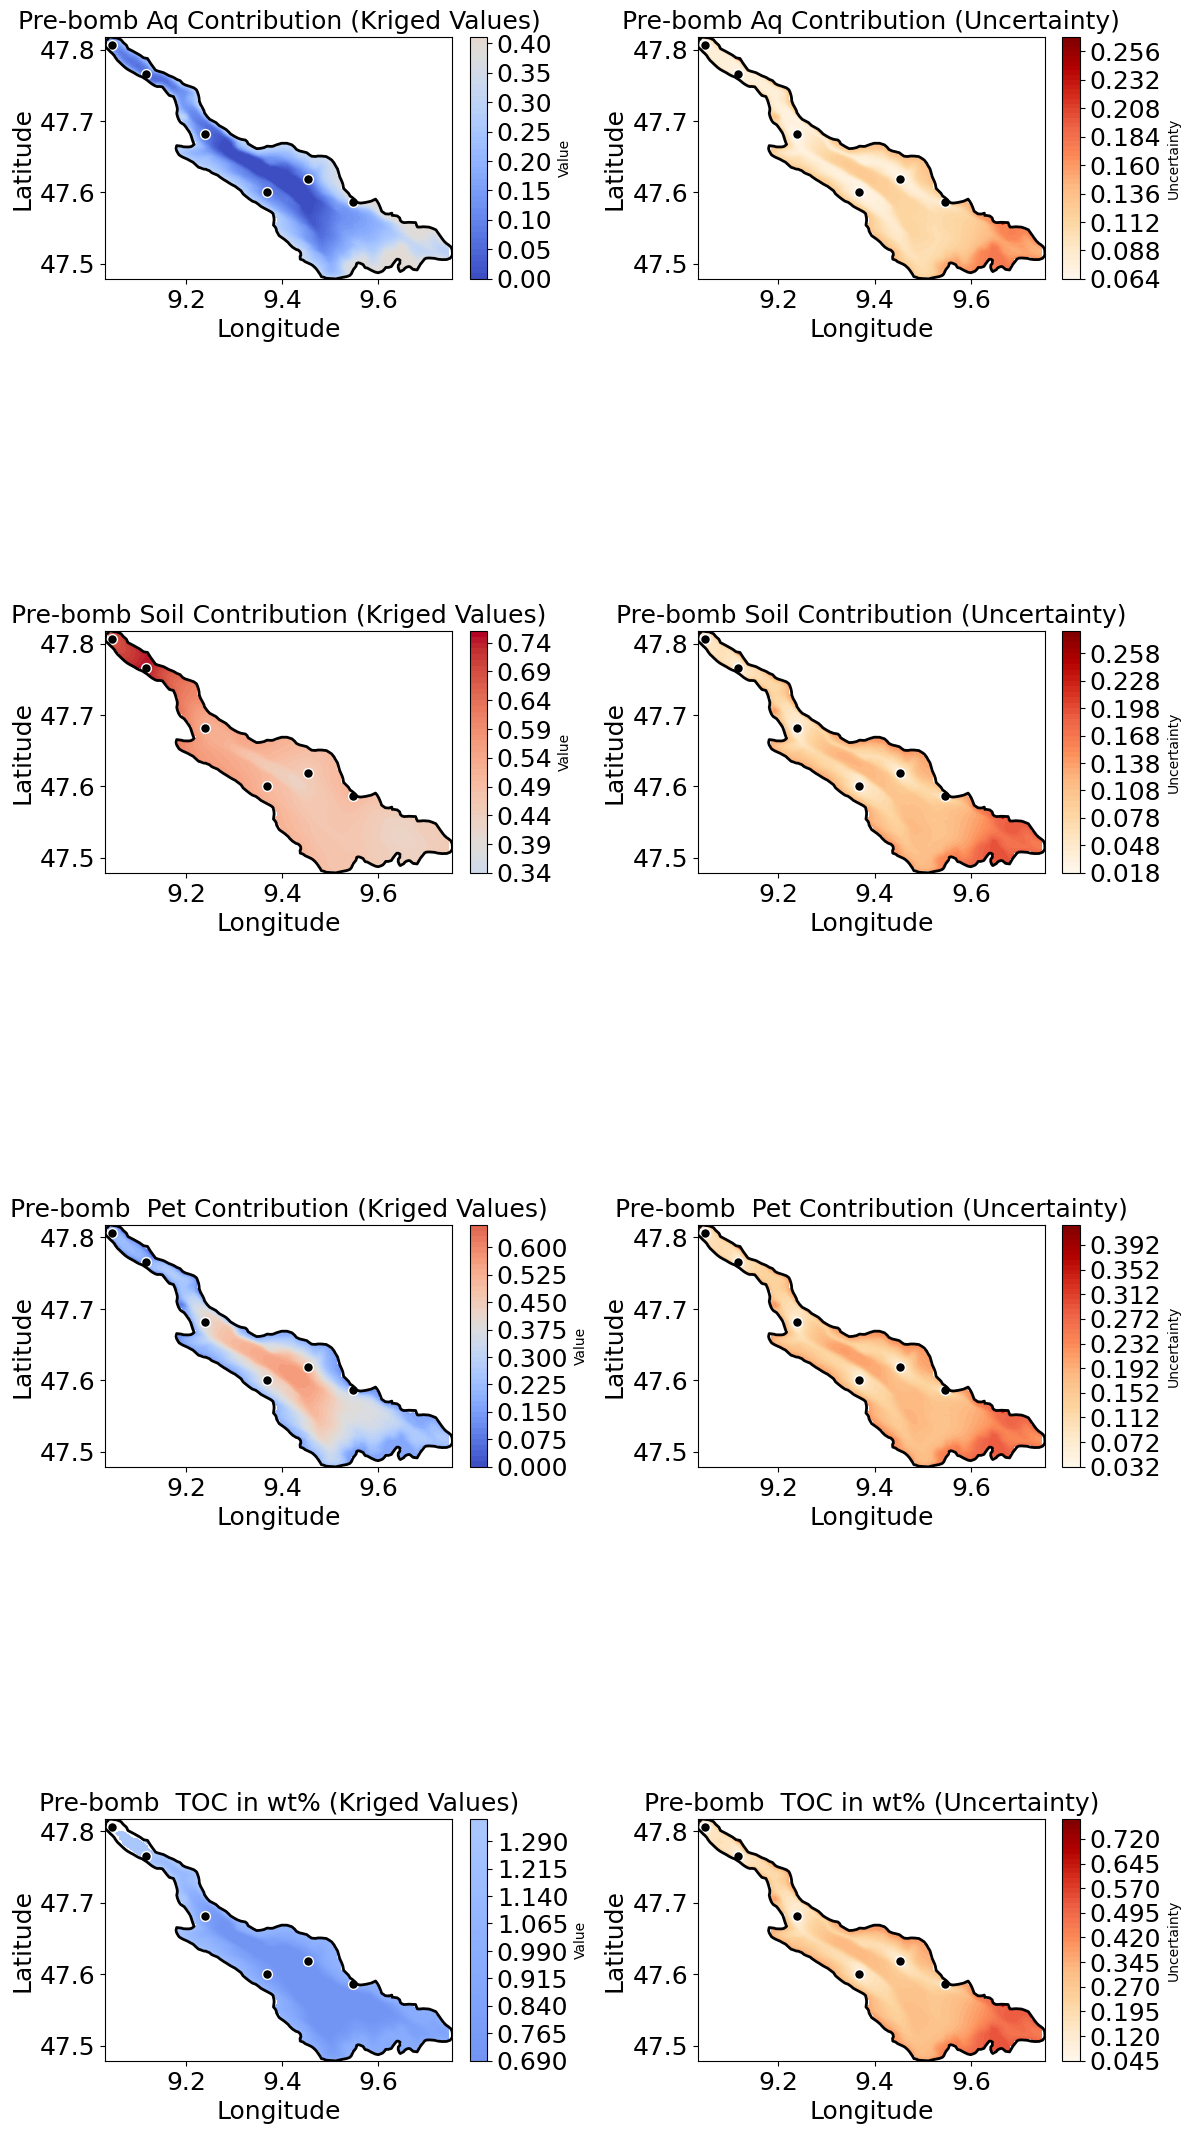

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 24)) 

# Plot each variable with its uncertainty next to it
plot_kriged_values([axes[0, 0], axes[0, 1]], grid_lon, grid_lat, Aq_pre_kriged, Aq_pre_uncertainty, lons, lats, 'Pre-bomb Aq Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[1, 0], axes[1, 1]], grid_lon, grid_lat, Soil_pre_kriged, Soil_pre_uncertainty, lons, lats, 'Pre-bomb Soil Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[2, 0], axes[2, 1]], grid_lon, grid_lat, Pet_pre_kriged, Pet_pre_uncertainty, lons, lats, 'Pre-bomb  Pet Contribution', lake, global_vmin, global_vmax)
plot_kriged_values([axes[3, 0], axes[3, 1]], grid_lon, grid_lat, TOC_pre_kriged, TOC_pre_uncertainty, lons, lats, 'Pre-bomb  TOC in wt%', lake, 0, 4) 

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

fig.savefig(OUTPUTDIR / "KrigingMapsRaw_Prebomb_NEW.svg", format="svg", dpi=600)

plt.show()

In [19]:
import numpy as np

# Number of simulations
N = 10000

# Arrays to store results
burial_flux_Aq_simulations = np.zeros(N)
burial_flux_Soil_simulations = np.zeros(N)
burial_flux_Pet_simulations = np.zeros(N)
TOC_flux_simulations = np.zeros(N)

OC_MAR_simulations = np.zeros(N)
OC_AqMAR_simulations = np.zeros(N)
OC_SoilMAR_simulations = np.zeros(N)
OC_PetMAR_simulations = np.zeros(N)

kriged_maps = [Aq_pre_kriged, Soil_pre_kriged, Pet_pre_kriged]
uncertainty_maps = [Aq_pre_uncertainty, Soil_pre_uncertainty, Pet_pre_uncertainty]


for i in range(N):
    # Randomly sample values based on uncertainties
    sampled_maps = [kriged + np.random.uniform(-3, 3, size=kriged.shape) * uncertainty for kriged, uncertainty in zip(kriged_maps, uncertainty_maps)]
    # Calculate burial flux for each carbon pool using sampled values and multiply by grid cell area
    burial_flux_Aq_simulations[i] = np.nansum(sampled_maps[0] * (TOC_pre_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    burial_flux_Soil_simulations[i] = np.nansum(sampled_maps[1] * (TOC_pre_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    burial_flux_Pet_simulations[i] = np.nansum(sampled_maps[2] * (TOC_pre_kriged/100) * Acc_kriged * grid_cell_area_cm2)
    TOC_flux_simulations[i] = burial_flux_Aq_simulations[i] + burial_flux_Soil_simulations[i] + burial_flux_Pet_simulations[i]
    
    OC_MAR_simulations[i] = np.nansum((burial_flux_Aq_simulations[i] + burial_flux_Soil_simulations[i] + burial_flux_Pet_simulations[i]) / surface_area_lake)
    OC_AqMAR_simulations[i] = burial_flux_Aq_simulations[i] / surface_area_lake
    OC_SoilMAR_simulations[i] = burial_flux_Soil_simulations[i] / surface_area_lake
    OC_PetMAR_simulations[i] = burial_flux_Pet_simulations[i] / surface_area_lake
        
# Calculate mean and standard deviation of everything
mean_Aq = np.mean(burial_flux_Aq_simulations)
std_Aq = np.std(burial_flux_Aq_simulations)
mean_Soil = np.mean(burial_flux_Soil_simulations)
std_Soil = np.std(burial_flux_Soil_simulations)
mean_Pet = np.mean(burial_flux_Pet_simulations)
std_Pet = np.std(burial_flux_Pet_simulations)
mean_TOC = np.mean(TOC_flux_simulations)
std_TOC = np.std(TOC_flux_simulations)


mean_OC_MAR = np.mean(OC_MAR_simulations)
std_OC_MAR = np.std(OC_MAR_simulations)
mean_AqOC_MAR = np.mean(OC_AqMAR_simulations)
std_AqOC_MAR = np.std(OC_AqMAR_simulations)
mean_SoilOC_MAR = np.mean(OC_SoilMAR_simulations)
std_SoilOC_MAR = np.std(OC_SoilMAR_simulations)
mean_PetOC_MAR = np.mean(OC_PetMAR_simulations)
std_PetOC_MAR = np.std(OC_PetMAR_simulations)


print(f"Aq: {mean_Aq:.2e} ± {std_Aq:.2e}")
print(f"Soil: {mean_Soil:.2e} ± {std_Soil:.2e}")
print(f"Pet: {mean_Pet:.2e} ± {std_Pet:.2e}")
print(f"TOC: {mean_TOC:.2e} ± {std_TOC:.2e}")

print(f"OC MAR: {mean_OC_MAR:.2e} ± {std_OC_MAR:.2e} g/m²/yr")
print(f"OCAq MAR: {mean_AqOC_MAR:.2e} ± {std_AqOC_MAR:.2e} g/m²/yr")
print(f"OCSoil MAR: {mean_SoilOC_MAR:.2e} ± {std_SoilOC_MAR:.2e} g/m²/yr")
print(f"OCPet MAR: {mean_PetOC_MAR:.2e} ± {std_PetOC_MAR:.2e} g/m²/yr")

Aq: 4.76e+09 ± 1.38e+08
Soil: 7.93e+09 ± 1.52e+08
Pet: 4.45e+09 ± 2.19e+08
TOC: 1.71e+10 ± 2.99e+08
OC MAR: 3.61e+01 ± 6.29e-01 g/m²/yr
OCAq MAR: 1.00e+01 ± 2.91e-01 g/m²/yr
OCSoil MAR: 1.67e+01 ± 3.19e-01 g/m²/yr
OCPet MAR: 9.37e+00 ± 4.62e-01 g/m²/yr


# Extrapolating Bulk D14C using MCMC results.

In [20]:
# Path to the CSV file
csv_file_path = INPUTDIR / "Delta14C_Endmembers.csv"
# Import the CSV file into a DataFrame
df_delta14C = pd.read_csv(csv_file_path)

# Prepare variables
years = df_delta14C['Year'].values
aq14C = df_delta14C['Aq14C'].values
aq14C_uncertainty = abs(df_delta14C['Aq14C_Uncertainty'].values)
soil14C = df_delta14C['Soil14C'].values
soil14C_uncertainty = abs(df_delta14C['Soil14C_Uncertainty'].values)

print(df_delta14C.head(100))

    Year       Aq14C  Aq14C_Uncertainty    Soil14C  Soil14C_Uncertainty
0   1900 -196.664670           0.127839  -5.988523             1.291389
1   1901 -197.006362           0.095310  -6.155023             1.286738
2   1902 -197.354988           0.064211  -6.326104             1.281669
3   1903 -197.709908           0.034530  -6.501718             1.276189
4   1904 -198.077853           0.005123  -6.681816             1.270307
..   ...         ...                ...        ...                  ...
95  1995  -46.873141           8.230667  81.611280             9.116724
96  1996  -53.960893           8.650570  81.415730             9.038263
97  1997  -60.694346           8.983830  81.162619             8.954774
98  1998  -67.192489           9.255427  80.849544             8.866061
99  1999  -73.527285           9.481180  80.478144             8.772336

[100 rows x 5 columns]


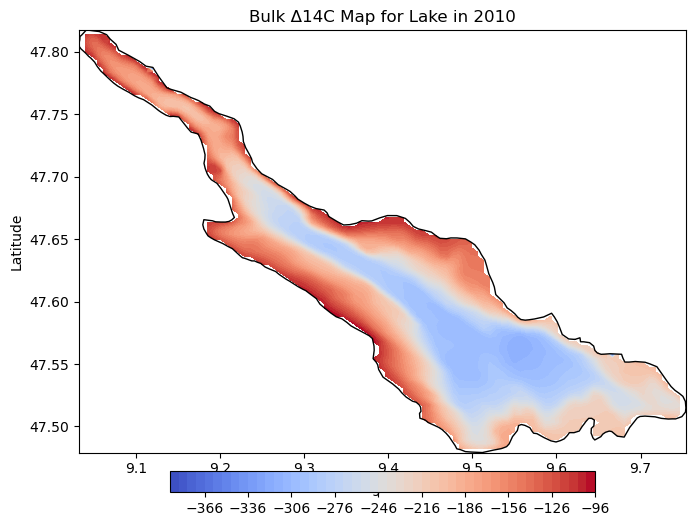

In [21]:
# Extract Δ14C for 2010
aq14C_2010 = df_delta14C[df_delta14C['Year'] == 2010]['Aq14C'].values[0]
soil14C_2010 = df_delta14C[df_delta14C['Year'] == 2010]['Soil14C'].values[0]
pet14C = -1000  # Assuming constant value for Pet OC

# Calculate bulk Δ14C for each point
bulk_14C = Aq_kriged * aq14C_2010 + Soil_kriged * soil14C_2010 + Pet_kriged * pet14C

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid_lon, grid_lat, bulk_14C, 50, cmap="coolwarm")
plt.colorbar(contour, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
ax.set_title("Bulk Δ14C Map for Lake in 2010")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
lake.boundary.plot(ax=ax, color='k', linewidth=1)  

plt.show()



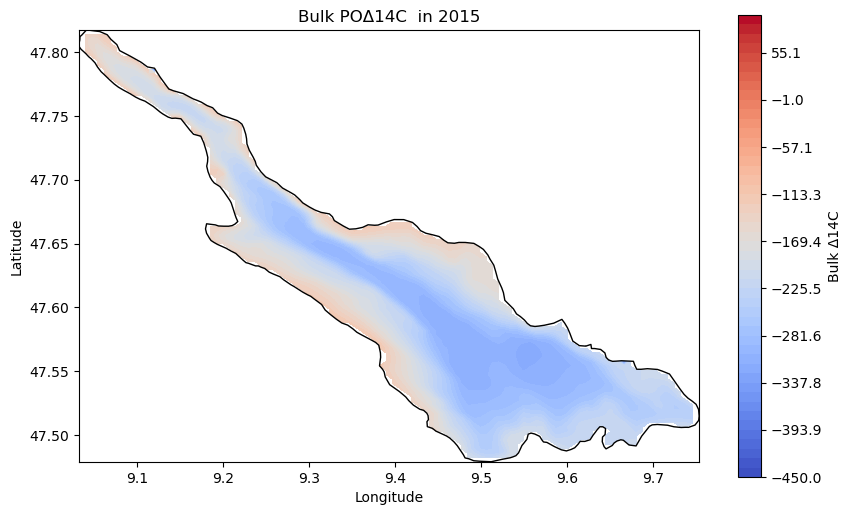

In [22]:
from matplotlib.animation import FuncAnimation

# Prepare the initial plot
fig, ax = plt.subplots(figsize=(10, 6))
lake_boundary, = ax.plot([], [], color='k', linewidth=1)

# Set the limits for the colorbar
vmin, vmax = -450, 100

# Initialize the contour plot for the colorbar
initial_bulk_14C = Aq_kriged * df_delta14C.loc[df_delta14C['Year'] == 1900, 'Aq14C'].values[0] + Soil_kriged * df_delta14C.loc[df_delta14C['Year'] == 1900, 'Soil14C'].values[0] + Pet_kriged * -1000
contour = ax.contourf(grid_lon, grid_lat, initial_bulk_14C, levels=np.linspace(vmin, vmax, 50), cmap="coolwarm", vmin=vmin, vmax=vmax)

# Create a colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Bulk Δ14C")

# Function to update the animation
def update(year):
    ax.clear()  # Clear previous contents
    # Get Δ14C values for the current year
    aq14C_current = df_delta14C.loc[df_delta14C['Year'] == year, 'Aq14C'].values[0]
    soil14C_current = df_delta14C.loc[df_delta14C['Year'] == year, 'Soil14C'].values[0]
    # Calculate bulk Δ14C
    bulk_14C_current = Aq_kriged * aq14C_current + Soil_kriged * soil14C_current + Pet_kriged * -1000
    # Update the contour plot with consistent colorbar limits
    ax.contourf(grid_lon, grid_lat, bulk_14C_current, levels=np.linspace(vmin, vmax, 50), cmap="coolwarm", vmin=vmin, vmax=vmax)
    # Redraw the lake boundary and title text
    lake.boundary.plot(ax=ax, color='k', linewidth=1)
    ax.set_title(f"Bulk POΔ14C  in {year}")
    # Update axes
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Create the animation
ani = FuncAnimation(fig, update, frames=range(1900, 2016))

# Save the animation
ani.save(OUTPUTDIR / 'bulk_14C_animation.gif', writer='pillow', fps=10)

plt.show()


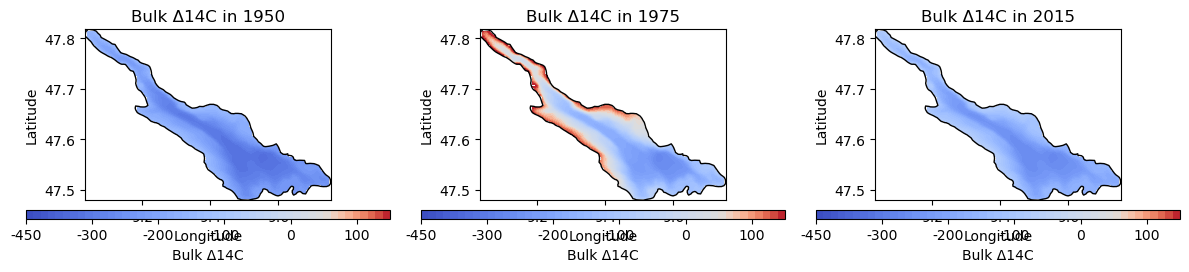

In [23]:
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Years to display
years = [1950, 1975, 2015]

# Set the limits for the colorbar
vmin, vmax = -450, 100

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, year in enumerate(years):
    ax = axes[i]
    # Get Δ14C values for the specified year
    aq14C_year = df_delta14C.loc[df_delta14C['Year'] == year, 'Aq14C'].values[0]
    soil14C_year = df_delta14C.loc[df_delta14C['Year'] == year, 'Soil14C'].values[0]
    # Calculate bulk Δ14C
    bulk_14C_year = Aq_kriged * aq14C_year + Soil_kriged * soil14C_year + Pet_kriged * -1000
    # Plot the bulk Δ14C
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    contour = ax.contourf(grid_lon, grid_lat, bulk_14C_year, levels=np.linspace(vmin, vmax, 50), cmap="coolwarm", norm=norm)
    # Draw the lake boundary
    lake.boundary.plot(ax=ax, color='k', linewidth=1)
    # Set title and axes labels
    ax.set_title(f"Bulk Δ14C in {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Create an axis on the right side of `ax`. The width of cax will be 5%
    # of ax and the padding between cax and ax will be 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    cbar = plt.colorbar(contour, cax=cax, orientation='horizontal', ticks=np.arange(vmin, vmax+50, 100)) #, extend='both'
    cbar.set_label("Bulk Δ14C")
    cbar.ax.set_xticklabels(['-450', '-300', '-200', '-100', '0', '100'])

plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR / "KrigingMapsRaw_for_Discussion.svg", format="svg", dpi=600)


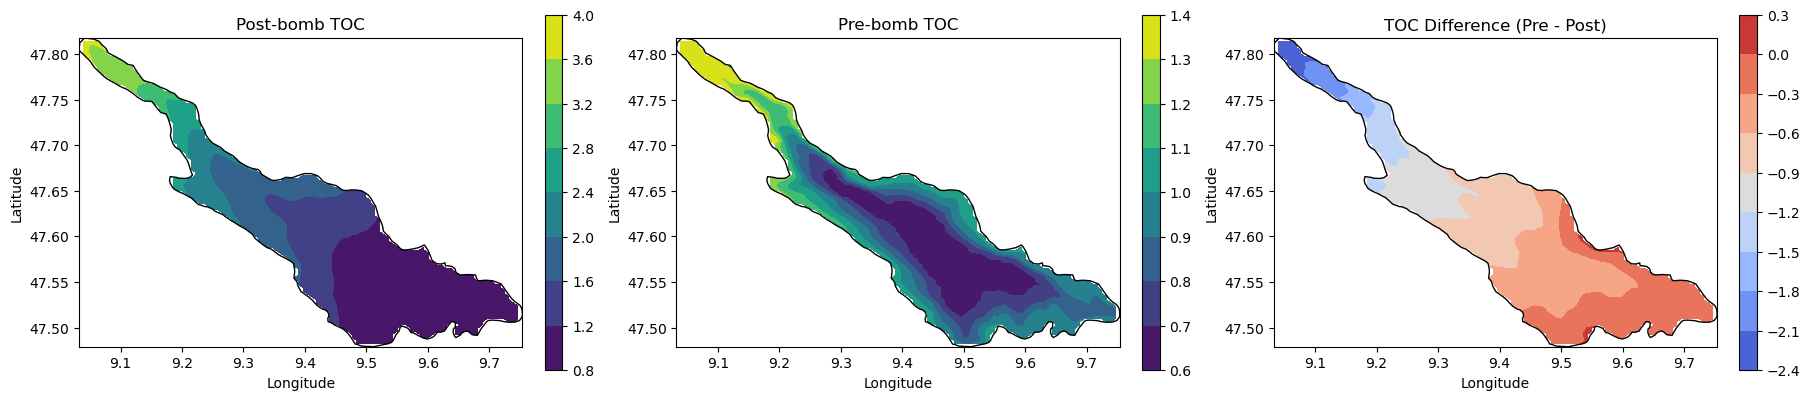

In [24]:
import matplotlib.pyplot as plt

# Assuming TOC_kriged (post-bomb) and TOC_pre_kriged (pre-bomb) are available
# Calculate the difference: TOC pre - TOC post
TOC_diff = TOC_pre_kriged - TOC_kriged

fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Post-bomb TOC map
pcm = axs[0].contourf(grid_lon, grid_lat, TOC_kriged, cmap="viridis")
fig.colorbar(pcm, ax=axs[0], shrink=0.6)
axs[0].set_title("Post-bomb TOC")

# Pre-bomb TOC map
pcm = axs[1].contourf(grid_lon, grid_lat, TOC_pre_kriged, cmap="viridis")
fig.colorbar(pcm, ax=axs[1], shrink=0.6)
axs[1].set_title("Pre-bomb TOC")

# Difference TOC map (Pre - Post)
pcm = axs[2].contourf(grid_lon, grid_lat, TOC_diff, cmap="coolwarm")
fig.colorbar(pcm, ax=axs[2], shrink=0.6)
axs[2].set_title("TOC Difference (Pre - Post)")

for ax in axs:
    lake.boundary.plot(ax=ax, color='k', linewidth=1)  # Assuming 'lake' is your GeoDataFrame of the lake boundary
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.show()

#The problem is that pre bomb TOC is higher in the delta, where there are actually no data points also